# ARIMA


In [63]:
# Load the saved model and make predictions on the test data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [64]:
# Import the data
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    # Convert 'date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [65]:
# Define the future covariates columns from your dataframe
future_covariates_no_lags = ['Solar_radiation (W/m2)', 'Wind_speed (m/s)', 'Temperature (°C)',
                             'Biomass (GWh)', 'Hard_coal (GWh)', 'Hydro (GWh)', 'Lignite (GWh)',
                             'Natural_gas (GWh)', 'Other (GWh)', 'Pumped_storage_generation (GWh)',
                             'Solar_energy (GWh)', 'Wind_offshore (GWh)', 'Wind_onshore (GWh)',
                             'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)',
                             'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)', 'Day_of_week', 'Month']

future_covariates_with_lags = ['Solar_radiation (W/m2)', 'Wind_speed (m/s)',
                               'Temperature (°C)', 'Biomass (GWh)', 'Hard_coal (GWh)', 'Hydro (GWh)',
                               'Lignite (GWh)', 'Natural_gas (GWh)', 'Other (GWh)',
                               'Pumped_storage_generation (GWh)', 'Solar_energy (GWh)',
                               'Wind_offshore (GWh)', 'Wind_onshore (GWh)',
                               'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)',
                               'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)', 'Lag_1_day',
                               'Lag_2_days', 'Lag_3_days', 'Lag_4_days', 'Lag_5_days', 'Lag_6_days',
                               'Lag_7_days', 'Day_of_week', 'Month', 'Rolling_mean_7']

In [66]:
# Load in the train and test data
train_df = load_and_prepare_data('../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../data/Final_data/test_df.csv')

# Concatenate the train and test data
df = pd.concat([train_df, test_df])
df['Date'] = pd.to_datetime(df['Date'])

df

,Date,Day_ahead_price (€/MWh),Solar_radiation (W/m2),Wind_speed (m/s),Temperature (°C),Biomass (GWh),Hard_coal (GWh),Hydro (GWh),Lignite (GWh),Natural_gas (GWh),...,Lag_1_day,Lag_2_days,Lag_3_days,Lag_4_days,Lag_5_days,Lag_6_days,Lag_7_days,Day_of_week,Month,Rolling_mean_7
0,2012-01-08,26.83,17.54,5.21,3.74,98.605,189.718,48.467,354.178,256.892,...,32.58,36.26,20.35,32.16,35.03,33.82,18.19,6,1,31.00
1,2012-01-09,47.91,13.04,4.24,3.80,98.605,344.154,49.054,382.756,282.438,...,26.83,32.58,36.26,20.35,32.16,35.03,33.82,0,1,33.02
2,2012-01-10,45.77,28.71,4.30,4.81,98.605,360.126,51.143,334.267,267.311,...,47.91,26.83,32.58,36.26,20.35,32.16,35.03,1,1,34.55
3,2012-01-11,47.83,21.58,4.08,5.14,98.605,360.330,50.693,385.000,277.343,...,45.77,47.91,26.83,32.58,36.26,20.35,32.16,2,1,36.79
4,2012-01-12,43.10,25.12,6.77,4.98,98.605,306.521,50.732,332.985,266.820,...,47.83,45.77,47.91,26.83,32.58,36.26,20.35,3,1,40.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,2024-07-24,66.61,225.04,3.47,17.54,110.007,43.469,85.857,199.246,194.291,...,79.62,88.75,58.45,59.32,86.47,90.75,76.79,2,7,75.71
755,2024-07-25,78.34,272.71,2.12,17.85,110.410,50.676,82.632,195.983,209.610,...,66.61,79.62,88.75,58.45,59.32,86.47,90.75,3,7,73.94
756,2024-07-26,93.04,172.33,2.60,19.09,110.852,42.333,79.531,205.273,205.773,...,78.34,66.61,79.62,88.75,58.45,59.32,86.47,4,7,74.88
757,2024-07-27,80.74,176.67,2.05,19.63,110.479,33.307,74.958,184.012,216.412,...,93.04,78.34,66.61,79.62,88.75,58.45,59.32,5,7,77.94


In [67]:
import plotly.graph_objects as go


def plot_sarima_forecast(sarima_forecasts, target_column="Day_ahead_price (€/MWh)"):
    """
    Plots the SARIMA forecast results with actual and predicted values,
    including a confidence band of +/- 1 standard deviation.

    Parameters:
    - sarima_forecasts (pd.DataFrame): DataFrame with 'date', 'actual', 'mean', and 'std' columns.
    - target_column (str): Title for the plot, representing the target variable.

    Returns:
    - fig (go.Figure): The Plotly figure object for further customization if needed.
    """
    fig = go.Figure()

    # Add actual data trace
    fig.add_trace(go.Scatter(
        x=sarima_forecasts["date"],
        y=sarima_forecasts["actual"],
        mode='lines',
        line=dict(color="#3f4751", width=1),
        name="Actual"
    ))

    # Add predicted mean trace
    fig.add_trace(go.Scatter(
        x=sarima_forecasts["date"],
        y=sarima_forecasts["mean"],
        mode='lines',
        line=dict(color="#ca8a04", width=1),
        name="Predicted"
    ))

    # Add predicted +/- 1 standard deviation band
    fig.add_trace(go.Scatter(
        x=sarima_forecasts["date"],
        y=sarima_forecasts["mean"] + sarima_forecasts["std"],
        fill=None,
        mode='lines',
        line=dict(color="#ca8a04", width=0.5),
        showlegend=False
    ))

    fig.add_trace(go.Scatter(
        x=sarima_forecasts["date"],
        y=sarima_forecasts["mean"] - sarima_forecasts["std"],
        fill='tonexty',  # Fill to previous trace
        mode='lines',
        line=dict(color="#ca8a04", width=0.5),
        name="Predicted +/- 1 Std. Dev.",
        opacity=0.2
    ))

    # Customize layout
    fig.update_layout(
        title=f"SARIMA Forecast for {target_column}",
        xaxis_title="Time",
        yaxis_title="Value",
        legend=dict(x=1.05, y=1),
        margin=dict(l=50, r=50, t=50, b=50),
        template="plotly",
        width=1500,
        height=450
    )

    # Show plot
    fig.show()

    return fig

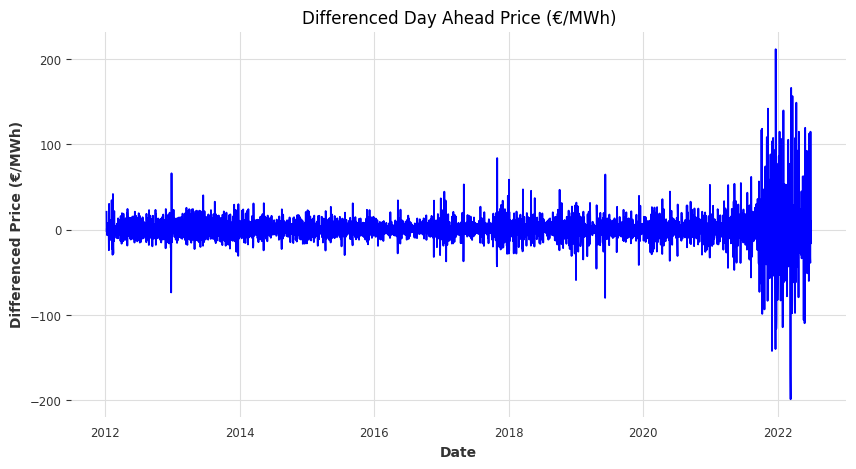

ADF Statistic: -15.429463005454169
p-value: 2.961677446374705e-28
KPSS Statistic: 0.41163254453847936
p-value: 0.07214114459548304


In [68]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt


df_diff = train_df.copy()

# Perform first-order differencing on the target variable
df_diff['Day_ahead_price_diff'] = df_diff['Day_ahead_price (€/MWh)'].diff(
).dropna()

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(df_diff['Date'], df_diff['Day_ahead_price_diff'], color='blue')
plt.title('Differenced Day Ahead Price (€/MWh)')
plt.xlabel('Date')
plt.ylabel('Differenced Price (€/MWh)')
plt.show()

# Perform ADF test on differenced data
adf_result = adfuller(df_diff['Day_ahead_price_diff'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Perform KPSS test on differenced data
kpss_stat, p_value, lags, crit_values = kpss(
    df_diff['Day_ahead_price_diff'].dropna())
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)

## Autoarima

In [ ]:
import plotly.graph_objects as go
import warnings
import transformers
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
from darts import TimeSeries


# Set flag for scenario (with or without lags)
include_lags = False  # Set to False if you don't want to include lags

# Determine the file path based on the include_lags flag
file_path = '../../data/Final_data/final_data_july.csv' if include_lags else '../../data/Final_data/final_data_no_lags.csv'

# Import the data
df = load_and_prepare_data(file_path)

# Reset the index
df = df.reset_index()

target_column = "Day_ahead_price (€/MWh)"

# date of first forecast
start_date = "2022-07-01"
# date of last forecast
end_date = "2024-07-28"

# create a TimeSeries object from df
data = df[['Date', target_column]]
# transform to a pandas series
data = data.set_index('Date')
data = data.squeeze()

#
best_sarima_model = auto_arima(
    y=data[data.index < start_date],
    start_p=0,
    start_q=0,
    start_P=0,
    start_Q=0,
    m=7,
    seasonal=True,
    stepwise=True
)

print(best_sarima_model.summary())

# create a list for storing the forecasts
sarima_forecasts = []

# loop across the dates
for t in tqdm(range(data.index.get_loc(start_date), data.index.get_loc(end_date) + 1)):

    # extract the training data
    context = data.iloc[:t]

    # train the model
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sarima_model = SARIMAX(
            endog=context,
            order=best_sarima_model.order,
            seasonal_order=best_sarima_model.seasonal_order,
            trend="c" if best_sarima_model.with_intercept else None,
        ).fit(disp=0)

    # generate the one-step-ahead forecast
    sarima_forecast = sarima_model.get_forecast(steps=1)

    # save the forecast
    sarima_forecasts.append({
        "date": data.index[t],
        "actual": data.values[t],
        "mean": sarima_forecast.predicted_mean.item(),
        "std": sarima_forecast.var_pred_mean.item() ** 0.5,
    })

# cast the forecasts to data frame
sarima_forecasts = pd.DataFrame(sarima_forecasts)

# Plot the forecast
fig = go.Figure()

# Add actual data trace
fig.add_trace(go.Scatter(
    x=sarima_forecasts["date"], y=sarima_forecasts["actual"],
    mode='lines', line=dict(color="#3f4751", width=1),
    name="Actual"
))

# Add predicted mean trace
fig.add_trace(go.Scatter(
    x=sarima_forecasts["date"], y=sarima_forecasts["mean"],
    mode='lines', line=dict(color="#ca8a04", width=1),
    name="Forecast"
))

# Add predicted +/- 1 standard deviation band
fig.add_trace(go.Scatter(
    x=sarima_forecasts["date"], y=sarima_forecasts["mean"] +
    sarima_forecasts["std"],
    fill=None, mode='lines', line=dict(color="#ca8a04", width=0.5), showlegend=False
))
fig.add_trace(go.Scatter(
    x=sarima_forecasts["date"], y=sarima_forecasts["mean"] -
    sarima_forecasts["std"],
    fill='tonexty', mode='lines', line=dict(color="#ca8a04", width=0.5),
    name="Forecast +/- 1 Std. Dev.", opacity=0.2
))

# Update layout
fig.update_layout(
    title=f"SARIMA Forecast for {target_column} {'with' if include_lags else 'without'} Lags",
    xaxis_title="Time", yaxis_title="Value",
    legend=dict(x=1.05, y=1),
    margin=dict(l=50, r=50, t=50, b=50),
    template="plotly_white",
    width=1500, height=450
)

# Save the plot as PNG
plot_path = f"sarima_forecast_plot_{'with' if include_lags else 'without'}_lags.png"
fig.write_image(plot_path)
print(f"Forecast plot saved at: {plot_path}")

# Calculate error metrics
rmse_value = mean_squared_error(
    sarima_forecasts["actual"], sarima_forecasts["mean"], squared=False)
mae_value = mean_absolute_error(
    sarima_forecasts["actual"], sarima_forecasts["mean"])
mape_value = mean_absolute_percentage_error(
    sarima_forecasts["actual"], sarima_forecasts["mean"])
smape_value = np.mean(
    np.abs(sarima_forecasts["actual"] - sarima_forecasts["mean"]) /
    ((np.abs(sarima_forecasts["actual"]) +
     np.abs(sarima_forecasts["mean"])) / 2)
)
mse_value = mean_squared_error(
    sarima_forecasts["actual"], sarima_forecasts["mean"])

# Print and save error metrics
print('Error Metrics on Test Set:')

print(f'RMSE: {rmse_value:.2f}')
print(f'MSE: {mse_value:.2f}')
print(f'MAE: {mae_value:.2f}')
print(f'MAPE: {mape_value:.2f}%')
print(f'SMAPE: {smape_value:.2f}%')

metrics_path = f"sarima_error_metrics_{'with' if include_lags else 'without'}_lags.csv"
metrics_df = pd.DataFrame({
    "Metric": ["MAPE", "MAE", "RMSE", "MSE", "SMAPE"],
    "Value": [mape_value, mae_value, rmse_value, mse_value, smape_value]
})
metrics_df.to_csv(metrics_path, index=False)
print(f"Error metrics saved at: {metrics_path}")

# Save the date and the forecasted values as CSV
forecast_path = f"forecasted_values_sarima_{'with' if include_lags else 'without'}_lags.csv"
forecast_df = pd.DataFrame({
    'Date': sarima_forecasts["date"],
    'Forecasted_price': sarima_forecasts["mean"]
})
forecast_df.to_csv(forecast_path, index=False)
print(f"Forecasted values saved at: {forecast_path}")

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 3827
Model:             SARIMAX(5, 1, 1)x(2, 0, [], 7)   Log Likelihood              -16145.858
Date:                            Sat, 02 Nov 2024   AIC                          32311.716
Time:                                    23:44:40   BIC                          32374.212
Sample:                                01-08-2012   HQIC                         32333.919
                                     - 06-30-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0083      0.007      1.269      0.204      -0.004       0.021
ar.L1          0.7517      0.006   

























































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 759/759 [1:26:23<00:00,  6.83s/it]

Forecast plot saved at: sarima_forecast_plot_without_lags.png
Error Metrics on Test Set:
RMSE: 37.30
MSE: 1391.33
MAE: 24.69
MAPE: 0.78%
SMAPE: 0.25%
Error metrics saved at: sarima_error_metrics_without_lags.csv
Forecasted values saved at: forecasted_values_sarima_without_lags.csv


In [75]:
# Set flag for scenario (with or without lags)
include_lags = False

# Determine file path based on flag
file_path = '../../data/Final_data/final_data_july.csv' if include_lags else '../../data/Final_data/final_data_no_lags.csv'

# Load the data
df = load_and_prepare_data(file_path)
df

,Date,Day_ahead_price (€/MWh),Solar_radiation (W/m2),Wind_speed (m/s),Temperature (°C),Biomass (GWh),Hard_coal (GWh),Hydro (GWh),Lignite (GWh),Natural_gas (GWh),...,Solar_energy (GWh),Wind_offshore (GWh),Wind_onshore (GWh),Net_total_export_import (GWh),BEV_vehicles,Oil_price (EUR),TTF_gas_price (€/MWh),Nuclear_energy (GWh),Day_of_week,Month
0,2012-01-08,26.83,17.54,5.21,3.74,98.605,189.718,48.467,354.178,256.892,...,8.039,3.639,251.722,26.066,6,103.71,21.33,286.206,6,1
1,2012-01-09,47.91,13.04,4.24,3.80,98.605,344.154,49.054,382.756,282.438,...,4.942,2.225,153.948,-59.712,6,103.64,22.45,294.593,0,1
2,2012-01-10,45.77,28.71,4.30,4.81,98.605,360.126,51.143,334.267,267.311,...,17.101,2.892,200.075,-31.384,6,104.22,21.95,293.534,1,1
3,2012-01-11,47.83,21.58,4.08,5.14,98.605,360.330,50.693,385.000,277.343,...,10.254,3.059,211.599,-2.110,6,103.93,21.95,295.340,2,1
4,2012-01-12,43.10,25.12,6.77,4.98,98.605,306.521,50.732,332.985,266.820,...,17.576,6.901,477.412,32.997,6,102.26,22.08,294.394,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4581,2024-07-24,66.61,225.04,3.47,17.54,110.007,43.469,85.857,199.246,194.291,...,325.285,49.360,179.921,-168.705,992,75.75,32.63,0.000,2,7
4582,2024-07-25,78.34,272.71,2.12,17.85,110.410,50.676,82.632,195.983,209.610,...,394.116,51.053,42.885,-194.496,992,76.36,31.70,0.000,3,7
4583,2024-07-26,93.04,172.33,2.60,19.09,110.852,42.333,79.531,205.273,205.773,...,256.246,40.449,129.267,-241.786,993,75.21,32.20,0.000,4,7
4584,2024-07-27,80.74,176.67,2.05,19.63,110.479,33.307,74.958,184.012,216.412,...,244.051,2.180,32.001,-251.655,992,74.79,32.90,0.000,5,7


In [ ]:
import pandas as pd
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set flag for scenario (with or without lags)
include_lags = False

# Determine file path based on flag
file_path = '../../data/Final_data/final_data_july.csv' if include_lags else '../../data/Final_data/final_data_no_lags.csv'

# Load the data
df = load_and_prepare_data(file_path)

target_column = "Day_ahead_price (€/MWh)"

# date of first forecast
start_date = "2022-07-01"
# date of last forecast
end_date = "2024-07-28"

# create a TimeSeries object from df
data = df[['Date', target_column]]
# transform to a pandas series
data = data.set_index('Date')
data = data.squeeze()
covariate_columns = future_covariates_with_lags if include_lags else future_covariates_no_lags

# Split the data into target and covariates
y = df[['Date', target_column]].set_index('Date')[target_column]
X = df[['Date'] + covariate_columns].set_index('Date')

# Define the training data (before the start date)
y_train = y[y.index < start_date]
X_train = X[X.index < start_date]

# Fit the model with covariates
best_sarima_model = auto_arima(
    y=y_train,
    X=X_train,  # Include covariates here
    start_p=0,
    start_q=0,
    start_P=0,
    start_Q=0,
    m=7,
    seasonal=True,
    stepwise=True
)

print(best_sarima_model.summary())

# Generate forecasts with covariates
forecast_start_date = "2022-07-01"
forecast_end_date = "2024-07-28"
X_forecast = X[(X.index >= forecast_start_date)
               & (X.index <= forecast_end_date)]
n_periods = len(X_forecast)

# Forecast using future covariates
forecast = best_sarima_model.predict(n_periods=n_periods, X=X_forecast)

# Create DataFrame for forecast results
forecast_df = pd.DataFrame({
    'Date': X_forecast.index,
    'Forecasted_price': forecast
})

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 3827
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood              -14626.761
Date:                                Sun, 03 Nov 2024   AIC                          29313.521
Time:                                        11:04:06   BIC                          29501.009
Sample:                                    01-08-2012   HQIC                         29380.131
                                         - 06-30-2022                                         
Covariance Type:                                  opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Solar_radiation (W/m2)             -0.00

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import numpy as np

# Merge actual and forecasted values based on the date to ensure alignment
result_df = df[['Date', target_column]].merge(
    forecast_df, on='Date', how='inner')
y_true = result_df[target_column].values  # Actual values
y_pred = result_df['Forecasted_price'].values  # Forecasted values

# Calculate error metrics
mape_value = mean_absolute_percentage_error(
    y_true, y_pred) * 100  # MAPE in percentage
mae_value = mean_absolute_error(y_true, y_pred)  # MAE
rmse_value = mean_squared_error(y_true, y_pred, squared=False)  # RMSE
mse_value = mean_squared_error(y_true, y_pred)  # MSE
smape_value = np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) +
                      np.abs(y_pred)) / 2)) * 100  # SMAPE in percentage

# Display the metrics
print("Error Metrics on Test Set:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"Mean Absolute Error (MAE): {mae_value:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_value:.2f}")
print(f"Mean Squared Error (MSE): {mse_value:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value:.2f}%")

# Save error metrics to a CSV file
metrics_path = f"sarima_error_metrics_{'with' if include_lags else 'without'}_lags.csv"
metrics_df = pd.DataFrame({
    "Metric": ["MAPE", "MAE", "RMSE", "MSE", "SMAPE"],
    "Value": [mape_value, mae_value, rmse_value, mse_value, smape_value]
})
metrics_df.to_csv(metrics_path, index=False)
print(f"Error metrics saved at: {metrics_path}")

# Save the date and the forecasted values as CSV
forecast_path = f"forecasted_values_sarima_{'with' if include_lags else 'without'}_lags.csv"
forecast_df.to_csv(forecast_path, index=False)
print(f"Forecasted values saved at: {forecast_path}")

Error Metrics on Test Set:
Mean Absolute Percentage Error (MAPE): 195.57%
Mean Absolute Error (MAE): 47.69
Root Mean Squared Error (RMSE): 55.44
Mean Squared Error (MSE): 3073.53
Symmetric Mean Absolute Percentage Error (SMAPE): 42.45%
Error metrics saved at: sarima_error_metrics_without_lags.csv
Forecasted values saved at: forecasted_values_sarima_without_lags.csv


In [ ]:
import plotly.graph_objects as go

# Plot the forecast
fig = go.Figure()

# Add actual data trace
fig.add_trace(go.Scatter(
    x=y[(y.index >= forecast_start_date) & (y.index <= forecast_end_date)].index, 
    y=y[(y.index >= forecast_start_date) & (y.index <= forecast_end_date)].values,
    mode='lines', line=dict(color="#3f4751", width=1),
    name="Actual"
))

# Add predicted mean trace
fig.add_trace(go.Scatter(
    x=forecast_df["Date"], y=forecast_df["Forecasted_price"],
    mode='lines', line=dict(color="#ca8a04", width=1),
    name="Forecast"
))


fig.add_trace(go.Scatter(
    x=forecast_df["Date"], y=forecast_df["Forecasted_price"] + forecast_std_dev,
    fill=None, mode='lines', line=dict(color="#ca8a04", width=0.5), showlegend=False
 ))
 fig.add_trace(go.Scatter(
     x=forecast_df["Date"], y=forecast_df["Forecasted_price"] - forecast_std_dev,
     fill='tonexty', mode='lines', line=dict(color="#ca8a04", width=0.5),
     name="Forecast +/- 1 Std. Dev.", opacity=0.2
 ))

# Update layout
fig.update_layout(
    title=f"SARIMA Forecast for {target_column} {'with' if include_lags else 'without'} Lags",
    xaxis_title="Time", yaxis_title="Value",
    legend=dict(x=1.05, y=1),
    margin=dict(l=50, r=50, t=50, b=50),
    template="plotly_white",
    width=1500, height=450
)

# Save the plot as PNG
plot_path = f"sarima_forecast_plot_{'with' if include_lags else 'without'}_lags.png"
fig.write_image(plot_path)
print(f"Forecast plot saved at: {plot_path}")


Forecast plot saved at: sarima_forecast_plot_without_lags.png


# Crossvalidation

In [ ]:
import numpy as np
import pmdarima as pm
import plotly.graph_objects as go
from pmdarima import model_selection
from matplotlib import pyplot as plt

print("pmdarima version: %s" % pm.__version__)

# Load the data and split it into separate pieces
y = pm.datasets.load_wineind()
est = pm.ARIMA(order=(1, 1, 2),
               seasonal_order=(0, 1, 1, 12),
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=150, step=4, h=4)
predictions = model_selection.cross_val_predict(
    est, y, cv=cv, verbose=2, averaging="median")

# plot the predictions over the original series
x_axis = np.arange(y.shape[0])
n_test = predictions.shape[0]

plt.plot(x_axis, y, alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated wineind forecasts")
plt.show()

In [71]:
from pmdarima.datasets import load_wineind

# this is a dataset from R
wineind = load_wineind().astype(np.float64)
wineind

array([15136., 16733., 20016., 17708., 18019., 19227., 22893., 23739.,
       21133., 22591., 26786., 29740., 15028., 17977., 20008., 21354.,
       19498., 22125., 25817., 28779., 20960., 22254., 27392., 29945.,
       16933., 17892., 20533., 23569., 22417., 22084., 26580., 27454.,
       24081., 23451., 28991., 31386., 16896., 20045., 23471., 21747.,
       25621., 23859., 25500., 30998., 24475., 23145., 29701., 34365.,
       17556., 22077., 25702., 22214., 26886., 23191., 27831., 35406.,
       23195., 25110., 30009., 36242., 18450., 21845., 26488., 22394.,
       28057., 25451., 24872., 33424., 24052., 28449., 33533., 37351.,
       19969., 21701., 26249., 24493., 24603., 26485., 30723., 34569.,
       26689., 26157., 32064., 38870., 21337., 19419., 23166., 28286.,
       24570., 24001., 33151., 24878., 26804., 28967., 33311., 40226.,
       20504., 23060., 23562., 27562., 23940., 24584., 34303., 25517.,
       23494., 29095., 32903., 34379., 16991., 21109., 23740., 25552.,
      